# **BigTransfer**

In [ ]:
import os
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

In [ ]:
dir='/content/drive/MyDrive/1108 HW Samples(Resized)/'
df=pd.read_csv('/content/drive/MyDrive/HW Samples (1108)/Label.csv')[[ 'FileName', 'Extraversion', 'Conscientiousness','Emotional Stability ', 'Agreeableness ', 'Open to Experience ']]

In [ ]:
set(['Average', 'High', 'Low', 'Very Low', 'average', 'high',
     ' High', 'Average', 'High', 'Low', 'Very High', 'Very high',
     'high', 'low','Average', 'High', 'Hihg', 'Low','Average',
     'High', 'Hihg', 'Low','Average', 'High', 'Low', 'lOW',
     'Average', 'High', 'Low'])

{' High',
 'Average',
 'High',
 'Hihg',
 'Low',
 'Very High',
 'Very Low',
 'Very high',
 'average',
 'high',
 'lOW',
 'low'}

In [ ]:
def code(x):
  if x in ['average','Average']:
    return 1
  elif x in [' High','High','Hihg','Very High','Very high','high']:
    return 2
  else:
    return 0

In [ ]:
for i in range(1,6):
  df.iloc[:,i]=df.iloc[:,i].apply(code)

In [ ]:
print('number of low class is {}, number average class is {} and number high of calss is {}'.format((df==0).sum().sum(),(df==1).sum().sum(),(df==2).sum().sum()))

number of low class is 373, number average class is 3205 and number high of calss is 1962


In [ ]:
file_paths=df['FileName'].values

_,_,files=next(os.walk(dir))

mark=[]
for i in file_paths:
  for j in files:
    if i == j[:-4]:
      mark.append(j)

file_path=np.array(mark)

In [ ]:
labels=df['Extraversion'] .values#, 'Conscientiousness', 'Emotional Stability ','Agreeableness ', 'Open to Experience '

In [ ]:
ds_train=tf.data.Dataset.from_tensor_slices((file_path,labels))

In [ ]:
next(iter(ds_train))

(<tf.Tensor: shape=(), dtype=string, numpy=b'1.jpg'>,
 <tf.Tensor: shape=(), dtype=int64, numpy=1>)

In [ ]:
RESIZE_TO = 384
CROP_TO = 224
BATCH_SIZE = 64
STEPS_PER_EPOCH = 10
AUTO = tf.data.AUTOTUNE  # optimise the pipeline performance
NUM_CLASSES = 3  # number of classes
SCHEDULE_LENGTH = (
    500  # we will train on lower resolution images and will still attain good results
)
SCHEDULE_BOUNDARIES = [
    200,
    300,
    400,
]
SCHEDULE_LENGTH = SCHEDULE_LENGTH * 512 / BATCH_SIZE

In [ ]:
@tf.function
def read_image(image_file,label):
  img=tf.io.read_file(dir+image_file)
  img=tf.image.decode_image(img,channels=3, expand_animations = False,dtype=tf.float32)

  img = tf.image.random_flip_left_right(img)
  img = tf.image.resize(img, (RESIZE_TO, RESIZE_TO))
  img = tf.image.random_crop(img, (CROP_TO, CROP_TO, 3))
  #img = img / 255.0
  return img,label


@tf.function
def preprocess_test(image_file, label):
  img=tf.io.read_file(dir+image_file)
  img=tf.image.decode_image(img,channels=3, expand_animations = False,dtype=tf.float32)
  img = tf.image.resize(img, (RESIZE_TO, RESIZE_TO))
  return (img, label)



DATASET_NUM_TRAIN_EXAMPLES = ds_train.cardinality().numpy()

repeat_count = int(
    SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH
)
repeat_count += 50 + 1  # To ensure at least there are 50 epochs of training

In [ ]:
train_size = int(0.7 * 1108)


ds_train=ds_train.shuffle(buffer_size=200)
train_dataset = ds_train.take(train_size)
val_dataset = ds_train.skip(train_size)

In [ ]:
# Training pipeline
pipeline_train = (
    train_dataset.repeat(repeat_count)  # Repeat dataset_size / num_steps
    .map(read_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Validation pipeline
pipeline_validation = (
    val_dataset.map(preprocess_test, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [ ]:
pipeline_train

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

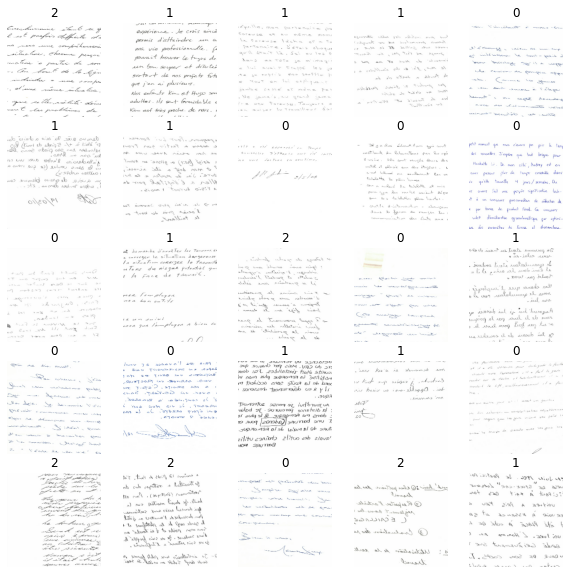

In [ ]:
image_batch, label_batch = next(iter(pipeline_train))

plt.figure(figsize=(8, 8))
for n in range(16):
    ax = plt.subplot(4, 4, n + 1)
    plt.imshow(image_batch[n])
    plt.title(label_batch[n].numpy())
    plt.axis("off")

In [ ]:
bit_model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
bit_module = hub.KerasLayer(bit_model_url)

In [ ]:
class MyBiTModel(keras.Model):
    def __init__(self, num_classes, module, **kwargs):
        super().__init__(**kwargs)

        self.num_classes = num_classes
        self.head1 = keras.layers.Dense(num_classes, kernel_initializer="zeros")
        self.head2 = keras.layers.Dense(num_classes, kernel_initializer="zeros")
        self.head3 = keras.layers.Dense(num_classes, kernel_initializer="zeros")
        self.head4 = keras.layers.Dense(num_classes, kernel_initializer="zeros")
        self.head5 = keras.layers.Dense(num_classes, kernel_initializer="zeros")
        self.bit_model = module

    def call(self, images):
        bit_embedding = self.bit_model(images)
        return [self.head1(bit_embedding),self.head2(bit_embedding),self.head3(bit_embedding),self.head4(bit_embedding),self.head5(bit_embedding)]


model = MyBiTModel(num_classes=NUM_CLASSES, module=bit_module)

In [ ]:
learning_rate = 0.003 * BATCH_SIZE / 512

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=SCHEDULE_BOUNDARIES,
    values=[
        learning_rate,
        learning_rate * 0.1,
        learning_rate * 0.01,
        learning_rate * 0.001,
    ],
)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

In [ ]:
train_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=2, restore_best_weights=True
    )
]

In [ ]:
history = model.fit(
    pipeline_train,
    batch_size=BATCH_SIZE,
    epochs=int(SCHEDULE_LENGTH / STEPS_PER_EPOCH),
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=pipeline_validation,
    callbacks=train_callbacks)

Epoch 1/400
10/10 [==============================] - 428s 42s/step - loss: 0.9903 - accuracy: 0.4906 - val_loss: 1.0689 - val_accuracy: 0.4505
Epoch 2/400
10/10 [==============================] - 297s 33s/step - loss: 0.9279 - accuracy: 0.5484 - val_loss: 0.9929 - val_accuracy: 0.4955
Epoch 3/400
10/10 [==============================] - 315s 35s/step - loss: 0.8584 - accuracy: 0.5859 - val_loss: 1.2144 - val_accuracy: 0.4595
Epoch 4/400
10/10 [==============================] - 307s 34s/step - loss: 0.9140 - accuracy: 0.5672 - val_loss: 1.1302 - val_accuracy: 0.4805


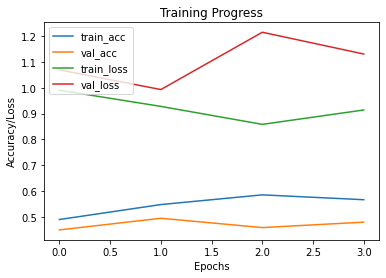

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Training Progress")
    plt.ylabel("Accuracy/Loss")
    plt.xlabel("Epochs")
    plt.legend(["train_acc", "val_acc", "train_loss", "val_loss"], loc="upper left")
    plt.show()


plot_hist(history)

# **VGGnet**

In [ ]:
import os
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import time
from tqdm import tqdm

In [ ]:
dir='/content/drive/MyDrive/1108 HW Samples(Resized)/'
df=pd.read_csv('/content/drive/MyDrive/HW Samples (1108)/Label.csv')[[ 'FileName', 'Extraversion', 'Conscientiousness','Emotional Stability ', 'Agreeableness ', 'Open to Experience ']]
def code(x):
  if x in ['average','Average']:
    return 1
  elif x in [' High','High','Hihg','Very High','Very high','high']:
    return 2
  else:
    return 0


for i in range(1,6):
  df.iloc[:,i]=df.iloc[:,i].apply(code)


file_paths=df['FileName'].values

_,_,files=next(os.walk(dir))

mark=[]
for i in file_paths:
  for j in files:
    if i == j[:-4]:
      mark.append(j)

file_path=np.array(mark)

y1=df['Extraversion'].values
y2=df['Conscientiousness'].values
y3=df['Emotional Stability '].values
y4=df['Agreeableness '].values
y5=df['Open to Experience '].values
ds_train=tf.data.Dataset.from_tensor_slices((file_path,y1,y2,y3,y4,y5))

In [ ]:
(df==1).sum()

FileName                  0
Extraversion            447
Conscientiousness       387
Emotional Stability     670
Agreeableness           947
Open to Experience      754
dtype: int64

In [ ]:
(df==0).sum()

FileName                  0
Extraversion            180
Conscientiousness        37
Emotional Stability       9
Agreeableness            99
Open to Experience       48
dtype: int64

In [ ]:
(df==2).sum()

FileName                  0
Extraversion            481
Conscientiousness       684
Emotional Stability     429
Agreeableness            62
Open to Experience      306
dtype: int64

In [ ]:
RESIZE_TO = 400
CROP_TO = 224
BATCH_SIZE = 32
AUTO = tf.data.AUTOTUNE

In [ ]:
@tf.function
def read_image(image_file,label1,label2,label3,label4,label5):
  img=tf.io.read_file(dir+image_file)
  img=tf.image.decode_image(img,channels=3, expand_animations = False,dtype=tf.float32)

  img = tf.image.random_flip_left_right(img)
  img = tf.image.resize(img, (RESIZE_TO, RESIZE_TO))
  img = tf.image.random_crop(img, (CROP_TO, CROP_TO, 3))
  img = (img / 127.5)-1
  return img,label1,label2,label3,label4,label5


@tf.function
def preprocess_test(image_file, label1,label2,label3,label4,label5):
  img=tf.io.read_file(dir+image_file)
  img=tf.image.decode_image(img,channels=3, expand_animations = False,dtype=tf.float32)

  img = tf.image.resize(img, (CROP_TO, CROP_TO))
  img = (img / 127.5)-1
  return (img, label1,label2,label3,label4,label5)

In [ ]:
train_size = int(0.9 * 1108)


ds_train=ds_train
train_dataset = ds_train.take(train_size)
val_dataset = ds_train.skip(train_size)

# Training pipeline
pipeline_train = (
    train_dataset.shuffle(buffer_size=200)
    .map(read_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Validation pipeline
pipeline_validation = (
    val_dataset.map(preprocess_test, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)name

In [ ]:
model=keras.applications.ResNet101V2(include_top=True)

179518384/179518384 [==============================] - 2s 0us/step


In [ ]:
for idx, layer in enumerate(model.layers):
  print(idx, layer.count_params)

In [ ]:
preprocess_input =tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
base_input=model.layers[0].input
out=model.layers[-2].output

In [ ]:
out1=layers.Dense(3)(out)
out2=layers.Dense(3)(out)
out3=layers.Dense(3)(out)
out4=layers.Dense(3)(out)
out5=layers.Dense(3)(out)

new_model=keras.Model(inputs=base_input,outputs=[out1,out2,out3,out4,out5])

In [ ]:
for layer in new_model.layers[:-20]:
  layer.trainable = False

In [ ]:
for layer in new_model.layers:
   print(layer.trainable)

In [ ]:
new_model.summary()

In [ ]:
tf.keras.utils.plot_model(new_model)

In [ ]:
learning_rate = 0.003 * BATCH_SIZE / 512
SCHEDULE_BOUNDARIES = [
    200,
    300,
    400,
]
# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=SCHEDULE_BOUNDARIES,
    values=[
        learning_rate,
        learning_rate * 0.1,
        learning_rate * 0.01,
        learning_rate * 0.001,
    ],
)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

In [ ]:
new_model.compile(optimizer=optimizer,
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'],
                  )

In [ ]:
loss_obj_1 = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss_obj_2 = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss_obj_3 = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss_obj_4 = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss_obj_5 = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

loss_cat1 = tf.keras.metrics.Mean(name='categorical loss')
loss_cat2 = tf.keras.metrics.Mean(name='categorical loss')
loss_cat3 = tf.keras.metrics.Mean(name='categorical loss')
loss_cat4 = tf.keras.metrics.Mean(name='categorical loss')
loss_cat5 = tf.keras.metrics.Mean(name='categorical loss')

error_cat1 = tf.keras.metrics.SparseCategoricalAccuracy()
error_cat2 = tf.keras.metrics.SparseCategoricalAccuracy()
error_cat3 = tf.keras.metrics.SparseCategoricalAccuracy()
error_cat4 = tf.keras.metrics.SparseCategoricalAccuracy()
error_cat5 = tf.keras.metrics.SparseCategoricalAccuracy()

verror_cat1 = tf.keras.metrics.SparseCategoricalAccuracy()
verror_cat2 = tf.keras.metrics.SparseCategoricalAccuracy()
verror_cat3 = tf.keras.metrics.SparseCategoricalAccuracy()
verror_cat4 = tf.keras.metrics.SparseCategoricalAccuracy()
verror_cat5 = tf.keras.metrics.SparseCategoricalAccuracy()

In [ ]:
epochs=5
for epoch in range(epochs):
  print("\nStart of epoch %d" % (epoch,))
  start_time = time.time()
  for step,(X, Y1,Y2,Y3,Y4,Y5) in tqdm(enumerate(pipeline_train)):
    with tf.GradientTape() as tape:

      pred_1, pred_2, pred_3, pred_4, pred_5 = new_model(X,training=True)

      cat_loss1 = loss_obj_1(Y1, pred_1)
      cat_loss2 = loss_obj_2(Y2, pred_2)
      cat_loss3 = loss_obj_3(Y3, pred_3)
      cat_loss4 = loss_obj_4(Y4, pred_4)
      cat_loss5 = loss_obj_5(Y5, pred_5)

    gradients = tape.gradient([cat_loss1,cat_loss2,cat_loss3,cat_loss4,cat_loss5], new_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, new_model.trainable_variables))

    error_cat1.update_state(Y1,pred_1)
    error_cat2.update_state(Y2,pred_2)
    error_cat3.update_state(Y3,pred_3)
    error_cat4.update_state(Y4,pred_4)
    error_cat5.update_state(Y5,pred_5)

    if step % 10 == 0:
      print('step: {}, Extraversion loss: {}, Conscientiousness loss: {}, Emotional Stability loss: {}, Agreeableness loss: {}, Open to Experience loss: {} '.format(step,cat_loss1,cat_loss2,cat_loss3,cat_loss4,cat_loss5))
      print("Seen so far: %d samples" % ((step + 1) * BATCH_SIZE))



  train_acc1=error_cat1.result()
  train_acc2=error_cat2.result()
  train_acc3=error_cat3.result()
  train_acc4=error_cat4.result()
  train_acc5=error_cat5.result()

  print('train acc over epoch ==> Extraversion acc: {}, Conscientiousness acc: {}, Emotional Stability acc: {}, Agreeableness acc: {}, Open to Experience acc: {} '.format(train_acc1,train_acc2,train_acc3,train_acc4,train_acc5))

  error_cat1.reset_states()
  error_cat2.reset_states()
  error_cat3.reset_states()
  error_cat4.reset_states()
  error_cat5.reset_states()

  for vX, vY1,vY2,vY3,vY4,vY5 in tqdm(pipeline_validation):

    vpred_1, vpred_2, vpred_3, vpred_4, vpred_5 = new_model(vX,training=False)

    verror_cat1.update_state(vY1,vpred_1)
    verror_cat2.update_state(vY2,vpred_2)
    verror_cat3.update_state(vY3,vpred_3)
    verror_cat4.update_state(vY4,vpred_4)
    verror_cat5.update_state(vY5,vpred_5)

  val_acc1=verror_cat1.result()
  val_acc2=verror_cat2.result()
  val_acc3=verror_cat3.result()
  val_acc4=verror_cat4.result()
  val_acc5=verror_cat5.result()

  verror_cat1.reset_states()
  verror_cat2.reset_states()
  verror_cat3.reset_states()
  verror_cat4.reset_states()
  verror_cat5.reset_states()
  print('validation acc over epoch ==> Extraversion acc: {}, Conscientiousness acc: {}, Emotional Stability acc: {}, Agreeableness acc: {}, Open to Experience acc: {} '.format(val_acc1,val_acc2,val_acc3,val_acc4,val_acc5))
  print("Time taken: %.2fs" % (time.time() - start_time))

# **Extraversion**

In [ ]:
import os
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import time
from tqdm import tqdm

In [ ]:
dir='/content/drive/MyDrive/HW Samples (1108)/1108 HW Samples.zip (Unzipped Files)/1108 HW Samples/'
df=pd.read_csv('/content/drive/MyDrive/HW Samples (1108)/Label.csv')[[ 'FileName', 'Extraversion', 'Conscientiousness','Emotional Stability ', 'Agreeableness ', 'Open to Experience ']]
def code(x):
  if x in ['average','Average']:
    return 1
  elif x in [' High','High','Hihg','Very High','Very high','high']:
    return 2
  else:
    return 0

In [ ]:
for i in range(1,6):
  df.iloc[:,i]=df.iloc[:,i].apply(code)

file_paths=df['FileName'].values

In [ ]:
_,_,files=next(os.walk(dir))
mark=[]
for i in file_paths:
  for j in files:
    if i == j[:-4]:
      mark.append(j)

file_path=np.array(mark)

In [ ]:
y=df['Extraversion'].values

In [ ]:
low, average, high = (df['Extraversion']==0).sum(),(df['Extraversion']==1).sum(),(df['Extraversion']==2).sum()
total = low+average+high
print('Examples:\n    Total: {}\n    low: {} ({:.2f}% of total)\n'.format(
    total, low, 100 * low / total))
print('Examples:\n    Total: {}\n    average: {} ({:.2f}% of total)\n'.format(
    total, average, 100 * average / total))
print('Examples:\n    Total: {}\n    high: {} ({:.2f}% of total)\n'.format(
    total, high, 100 * high / total))

Examples:
    Total: 1108
    low: 180 (16.25% of total)

Examples:
    Total: 1108
    average: 447 (40.34% of total)

Examples:
    Total: 1108
    high: 481 (43.41% of total)



In [ ]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / low) * (total / 3.0)
weight_for_1 = (1 / average) * (total / 3.0)
weight_for_2 = (1 / high) * (total / 3.0)
class_weight = {0: weight_for_0, 1: weight_for_1, 2:weight_for_2}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 1: {:.2f}'.format(weight_for_2))

Weight for class 0: 2.05
Weight for class 1: 0.83
Weight for class 1: 0.77


In [ ]:
RESIZE_TO = 400
CROP_TO = 299
BATCH_SIZE = 32
SCHEDULE_LENGTH = (
    500  # we will train on lower resolution images and will still attain good results
)
AUTO = tf.data.AUTOTUNE

In [ ]:
@tf.function
def read_image(image_file,label):
  img=tf.io.read_file(dir+image_file)
  img=tf.image.decode_image(img,channels=3, expand_animations = False,dtype=tf.float32)
  img = tf.image.random_flip_left_right(img)
  img = tf.image.resize(img, (RESIZE_TO, RESIZE_TO))
  img = tf.image.random_crop(img, (CROP_TO, CROP_TO, 3))
  #img = (img / 127.5)-1
  return img,label


@tf.function
def preprocess_test(image_file, label):
  img=tf.io.read_file(dir+image_file)
  img=tf.image.decode_image(img,channels=3, expand_animations = False,dtype=tf.float32)
  img = tf.image.resize(img, (CROP_TO, CROP_TO))
  #img = (img / 127.5)-1
  return (img, label)

In [ ]:
train_size = int(0.9 * 1108)

ds_train=tf.data.Dataset.from_tensor_slices((file_path,y))
ds_train=ds_train
train_dataset = ds_train.take(train_size)
val_dataset = ds_train.skip(train_size)

# Training pipeline
pipeline_train = (
    train_dataset.shuffle(buffer_size=200)
    .map(read_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Validation pipeline
pipeline_validation = (
    val_dataset.map(preprocess_test, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [ ]:
model=keras.applications.Xception(include_top=True)

91897856/91884032 [==============================] - 1s 0us/step


In [ ]:
base_input=model.layers[0].input
out=model.layers[-2].output

In [ ]:
out1=layers.Dense(3)(out)
new_model=keras.Model(inputs=base_input,outputs=out1)

In [ ]:
for layer in new_model.layers[:-10]:
  if layer.trainable ==True:
    layer.trainable = False

In [ ]:
tf.keras.utils.plot_model(new_model)

In [ ]:
learning_rate = 0.003 * BATCH_SIZE / 512
SCHEDULE_BOUNDARIES = [
    200,
    300,
    400,
]
# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=SCHEDULE_BOUNDARIES,
    values=[
        learning_rate,
        learning_rate * 0.1,
        learning_rate * 0.01,
        learning_rate * 0.001,
    ],
)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)
loss_fn = keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])
train_callbacks = [
    keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True
                                  )
    ]

In [ ]:
history = model.fit(
    pipeline_train,
    batch_size=BATCH_SIZE,
    validation_data=pipeline_validation,
    callbacks=train_callbacks,
    class_weight=class_weight
)

32/32 [==============================] - 276s 8s/step - loss: 5.2325 - accuracy: 0.2859 - val_loss: 3.5323 - val_accuracy: 0.1171


In [ ]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Training Progress")
    plt.ylabel("Accuracy/Loss")
    plt.xlabel("Epochs")
    plt.legend(["train_acc", "val_acc", "train_loss", "val_loss"], loc="upper left")
    plt.show()


plot_hist(history)

# **Conscientiousness**

In [ ]:
import os
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import time
from tqdm import tqdm
dir='/content/drive/MyDrive/HW Samples (1108)/1108 HW Samples.zip (Unzipped Files)/1108 HW Samples/'
df=pd.read_csv('/content/drive/MyDrive/HW Samples (1108)/Label.csv')[[ 'FileName', 'Extraversion', 'Conscientiousness','Emotional Stability ', 'Agreeableness ', 'Open to Experience ']]
def code(x):
  if x in ['average','Average']:
    return 1
  elif x in [' High','High','Hihg','Very High','Very high','high']:
    return 2
  else:
    return 0

for i in range(1,6):
  df.iloc[:,i]=df.iloc[:,i].apply(code)

file_paths=df['FileName'].values

_,_,files=next(os.walk(dir))
mark=[]
for i in file_paths:
  for j in files:
    if i == j[:-4]:
      mark.append(j)

file_path=np.array(mark)
y=df['Conscientiousness'].values

low, average, high = (df['Conscientiousness']==0).sum(),(df['Conscientiousness']==1).sum(),(df['Conscientiousness']==2).sum()
total = low+average+high
print('Examples:\n    Total: {}\n    low: {} ({:.2f}% of total)\n'.format(
    total, low, 100 * low / total))
print('Examples:\n    Total: {}\n    average: {} ({:.2f}% of total)\n'.format(
    total, average, 100 * average / total))
print('Examples:\n    Total: {}\n    high: {} ({:.2f}% of total)\n'.format(
    total, high, 100 * high / total))

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / low) * (total / 3.0)
weight_for_1 = (1 / average) * (total / 3.0)
weight_for_2 = (1 / high) * (total / 3.0)
class_weight = {0: weight_for_0, 1: weight_for_1, 2:weight_for_2}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 1: {:.2f}'.format(weight_for_2))

RESIZE_TO = 400
CROP_TO = 299
BATCH_SIZE = 32
SCHEDULE_LENGTH = (
    500  # we will train on lower resolution images and will still attain good results
)
AUTO = tf.data.AUTOTUNE
@tf.function
def read_image(image_file,label):
  img=tf.io.read_file(dir+image_file)
  img=tf.image.decode_image(img,channels=3, expand_animations = False,dtype=tf.float32)
  img = tf.image.random_flip_left_right(img)
  img = tf.image.resize(img, (RESIZE_TO, RESIZE_TO))
  img = tf.image.random_crop(img, (CROP_TO, CROP_TO, 3))
  #img = (img / 127.5)-1
  return img,label


@tf.function
def preprocess_test(image_file, label):
  img=tf.io.read_file(dir+image_file)
  img=tf.image.decode_image(img,channels=3, expand_animations = False,dtype=tf.float32)
  img = tf.image.resize(img, (CROP_TO, CROP_TO))
  #img = (img / 127.5)-1
  return (img, label)

train_size = int(0.9 * 1108)

ds_train=tf.data.Dataset.from_tensor_slices((file_path,y))
ds_train=ds_train
train_dataset = ds_train.take(train_size)
val_dataset = ds_train.skip(train_size)

# Training pipeline
pipeline_train = (
    train_dataset.shuffle(buffer_size=200)
    .map(read_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Validation pipeline
pipeline_validation = (
    val_dataset.map(preprocess_test, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

Examples:
    Total: 1108
    low: 37 (3.34% of total)

Examples:
    Total: 1108
    average: 387 (34.93% of total)

Examples:
    Total: 1108
    high: 684 (61.73% of total)

Weight for class 0: 9.98
Weight for class 1: 0.95
Weight for class 1: 0.54


In [ ]:
model=keras.applications.Xception(include_top=True)

In [ ]:
base_input=model.layers[0].input
out=model.layers[-2].output

In [ ]:
out1=layers.Dense(3)(out)
new_model=keras.Model(inputs=base_input,outputs=out1)

In [ ]:
for layer in new_model.layers[:-10]:
  if layer.trainable ==True:
    layer.trainable = False

In [ ]:
tf.keras.utils.plot_model(new_model)

In [ ]:
learning_rate = 0.003 * BATCH_SIZE / 512
SCHEDULE_BOUNDARIES = [
    200,
    300,
    400,
]
# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=SCHEDULE_BOUNDARIES,
    values=[
        learning_rate,
        learning_rate * 0.1,
        learning_rate * 0.01,
        learning_rate * 0.001,
    ],
)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)
loss_fn = keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])
train_callbacks = [
    keras.callbacks.EarlyStopping( patience=2, restore_best_weights=True
                                  )
    ]

In [ ]:
history = model.fit(
    pipeline_train,
    epochs=5,
    batch_size=BATCH_SIZE,
    validation_data=pipeline_validation,
    callbacks=train_callbacks,
    #class_weight=class_weight
)

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Training Progress")
    plt.ylabel("Accuracy/Loss")
    plt.xlabel("Epochs")
    plt.legend(["train_acc", "val_acc", "train_loss", "val_loss"], loc="upper left")
    plt.show()


plot_hist(history)

In [ ]:
import os
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import time
from tqdm import tqdm
dir='/content/drive/MyDrive/HW Samples (1108)/1108 HW Samples.zip (Unzipped Files)/1108 HW Samples/'
df=pd.read_csv('/content/drive/MyDrive/HW Samples (1108)/Label.csv')[[ 'FileName', 'Extraversion', 'Conscientiousness','Emotional Stability ', 'Agreeableness ', 'Open to Experience ']]
def code(x):
  if x in ['average','Average']:
    return 1
  elif x in [' High','High','Hihg','Very High','Very high','high']:
    return 2
  else:
    return 0

for i in range(1,6):
  df.iloc[:,i]=df.iloc[:,i].apply(code)

file_paths=df['FileName'].values

_,_,files=next(os.walk(dir))
mark=[]
for i in file_paths:
  for j in files:
    if i == j[:-4]:
      mark.append(j)

file_path=np.array(mark)
y=df['Emotional Stability '].values

low, average, high = (df['Emotional Stability ']==0).sum(),(df['Emotional Stability ']==1).sum(),(df['Emotional Stability ']==2).sum()
total = low+average+high
print('Examples:\n    Total: {}\n    low: {} ({:.2f}% of total)\n'.format(
    total, low, 100 * low / total))
print('Examples:\n    Total: {}\n    average: {} ({:.2f}% of total)\n'.format(
    total, average, 100 * average / total))
print('Examples:\n    Total: {}\n    high: {} ({:.2f}% of total)\n'.format(
    total, high, 100 * high / total))

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / low) * (total / 3.0)
weight_for_1 = (1 / average) * (total / 3.0)
weight_for_2 = (1 / high) * (total / 3.0)
class_weight = {0: weight_for_0, 1: weight_for_1, 2:weight_for_2}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 1: {:.2f}'.format(weight_for_2))

RESIZE_TO = 400
CROP_TO = 299
BATCH_SIZE = 32
SCHEDULE_LENGTH = (
    500  # we will train on lower resolution images and will still attain good results
)
AUTO = tf.data.AUTOTUNE
@tf.function
def read_image(image_file,label):
  img=tf.io.read_file(dir+image_file)
  img=tf.image.decode_image(img,channels=3, expand_animations = False,dtype=tf.float32)
  img = tf.image.random_flip_left_right(img)
  img = tf.image.resize(img, (RESIZE_TO, RESIZE_TO))
  img = tf.image.random_crop(img, (CROP_TO, CROP_TO, 3))
  #img = (img / 127.5)-1
  return img,label


@tf.function
def preprocess_test(image_file, label):
  img=tf.io.read_file(dir+image_file)
  img=tf.image.decode_image(img,channels=3, expand_animations = False,dtype=tf.float32)
  img = tf.image.resize(img, (CROP_TO, CROP_TO))
  #img = (img / 127.5)-1
  return (img, label)

train_size = int(0.9 * 1108)

ds_train=tf.data.Dataset.from_tensor_slices((file_path,y))
ds_train=ds_train
train_dataset = ds_train.take(train_size)
val_dataset = ds_train.skip(train_size)

# Training pipeline
pipeline_train = (
    train_dataset.shuffle(buffer_size=200)
    .map(read_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Validation pipeline
pipeline_validation = (
    val_dataset.map(preprocess_test, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

Examples:
    Total: 1108
    low: 9 (0.81% of total)

Examples:
    Total: 1108
    average: 670 (60.47% of total)

Examples:
    Total: 1108
    high: 429 (38.72% of total)

Weight for class 0: 41.04
Weight for class 1: 0.55
Weight for class 1: 0.86


In [ ]:
model=keras.applications.Xception(include_top=True)

In [ ]:
base_input=model.layers[0].input
out=model.layers[-2].output
out1=layers.Dense(3)(out)
new_model=keras.Model(inputs=base_input,outputs=out1)
for layer in new_model.layers[:-10]:
  if layer.trainable ==True:
    layer.trainable = False
tf.keras.utils.plot_model(new_model)

In [ ]:
learning_rate = 0.003 * BATCH_SIZE / 512
SCHEDULE_BOUNDARIES = [
    200,
    300,
    400,
]
# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=SCHEDULE_BOUNDARIES,
    values=[
        learning_rate,
        learning_rate * 0.1,
        learning_rate * 0.01,
        learning_rate * 0.001,
    ],
)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)
loss_fn = keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])
train_callbacks = [
    keras.callbacks.EarlyStopping( patience=2, restore_best_weights=True
                                  )
    ]

In [ ]:
history = model.fit(

    pipeline_train,
    epochs=5,
    batch_size=BATCH_SIZE,
    validation_data=pipeline_validation,
    callbacks=train_callbacks,
    class_weight=class_weight
)

Epoch 1/5
32/32 [==============================] - 278s 8s/step - loss: 3.8900 - accuracy: 0.4714 - val_loss: 1.7915 - val_accuracy: 0.1261
Epoch 2/5
32/32 [==============================] - 257s 8s/step - loss: 3.2078 - accuracy: 0.5587 - val_loss: 1.6987 - val_accuracy: 0.1351
Epoch 3/5
32/32 [==============================] - 257s 8s/step - loss: 2.7590 - accuracy: 0.5216 - val_loss: 1.7588 - val_accuracy: 0.1622
Epoch 4/5
32/32 [==============================] - 256s 8s/step - loss: 2.3535 - accuracy: 0.5456 - val_loss: 1.8618 - val_accuracy: 0.2252


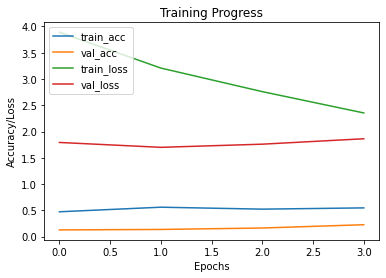

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Training Progress")
    plt.ylabel("Accuracy/Loss")
    plt.xlabel("Epochs")
    plt.legend(["train_acc", "val_acc", "train_loss", "val_loss"], loc="upper left")
    plt.show()


plot_hist(history)

# **Agreeableness**

In [ ]:
import os
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import time
from tqdm import tqdm
dir='/content/drive/MyDrive/HW Samples (1108)/1108 HW Samples.zip (Unzipped Files)/1108 HW Samples/'
df=pd.read_csv('/content/drive/MyDrive/HW Samples (1108)/Label.csv')[[ 'FileName', 'Extraversion', 'Conscientiousness','Emotional Stability ', 'Agreeableness ', 'Open to Experience ']]
def code(x):
  if x in ['average','Average']:
    return 1
  elif x in [' High','High','Hihg','Very High','Very high','high']:
    return 2
  else:
    return 0

for i in range(1,6):
  df.iloc[:,i]=df.iloc[:,i].apply(code)

file_paths=df['FileName'].values

_,_,files=next(os.walk(dir))
mark=[]
for i in file_paths:
  for j in files:
    if i == j[:-4]:
      mark.append(j)

file_path_train=np.array(mark)[:1000]
y_train=df['Open to Experience '].values[:1000]
file_path_test=np.array(mark)[1000:]
y_test=df['Open to Experience '].values[1000:]


RESIZE_TO = 400
CROP_TO = 299
BATCH_SIZE = 8
SCHEDULE_LENGTH = (
    500  # we will train on lower resolution images and will still attain good results
)
from imblearn.over_sampling import SMOTE
invert_paths={}
for i in range(1000):
  invert_paths[file_path_train[i]]=i

invert_paths1=dict((value,key ) for (key, value) in invert_paths.items())

smt = SMOTE()
Xs_train, ys_train = smt.fit_resample(np.array(list(invert_paths.values())).reshape(-1,1), y_train.reshape(-1,1))
Xs_train=Xs_train.flatten()
ys_train=ys_train.flatten()
x=np.array([invert_paths1[i] for i in Xs_train])
AUTO = tf.data.AUTOTUNE
@tf.function
def read_image(image_file,label):
  img=tf.io.read_file(dir+image_file)
  img=tf.image.decode_image(img,channels=3, expand_animations = False,dtype=tf.float32)
  #img = tf.image.random_flip_left_right(img)
  img = tf.image.resize(img, (5000, 5000))
  img = tf.image.random_crop(img, (400, 400, 3))
  #img = (img / 127.5)-1
  return img,label


@tf.function
def preprocess_test(image_file, label):
  img=tf.io.read_file(dir+image_file)
  img=tf.image.decode_image(img,channels=3, expand_animations = False,dtype=tf.float32)
  img = tf.image.resize(img, (5000, 5000))
  img = tf.image.random_crop(img, (400, 400, 3))
  #img = (img / 127.5)-1
  return (img, label)

#train_size = int(0.9 * 1108)

ds_train=tf.data.Dataset.from_tensor_slices((x,ys_train))
ds_test=tf.data.Dataset.from_tensor_slices((file_path_test,y_test))
#train_dataset = ds_train.take(train_size)
#val_dataset = ds_train.skip(train_size)

# Training pipeline
pipeline_train = (
    ds_train.shuffle(buffer_size=200)
    .map(read_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Validation pipeline
pipeline_validation = (
    ds_test.map(preprocess_test, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [ ]:
model=keras.applications.Xception(include_top=True)

91897856/91884032 [==============================] - 0s 0us/step


In [ ]:
base_input=model.layers[0].input
out=model.layers[-2].output
out1=layers.Dense(3)(out)
new_model=keras.Model(inputs=base_input,outputs=out1)
for layer in new_model.layers[:-10]:
  if layer.trainable ==True:
    layer.trainable = False
#tf.keras.utils.plot_model(new_model)

In [ ]:
learning_rate = 0.003 * BATCH_SIZE / 512
SCHEDULE_BOUNDARIES = [
    200,
    300,
    400,
]
# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=SCHEDULE_BOUNDARIES,
    values=[
        learning_rate,
        learning_rate * 0.1,
        learning_rate * 0.01,
        learning_rate * 0.001,
    ],
)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)
loss_fn = keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])
train_callbacks = [
    keras.callbacks.EarlyStopping( patience=2, restore_best_weights=True
                                  )
    ]

In [ ]:
history = model.fit(

    pipeline_train,
    epochs=10,
    batch_size=BATCH_SIZE,
    validation_data=pipeline_validation,
    callbacks=train_callbacks)

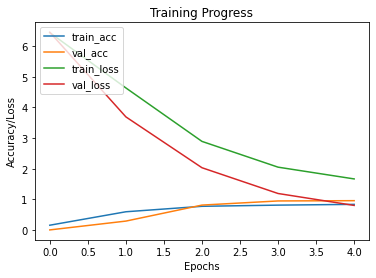

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Training Progress")
    plt.ylabel("Accuracy/Loss")
    plt.xlabel("Epochs")
    plt.legend(["train_acc", "val_acc", "train_loss", "val_loss"], loc="upper left")
    plt.show()


plot_hist(history)

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        #layers.RandomCrop(400,400),
        layers.RandomZoom(0.2),
        layers.RandomWidth((0.2, 0.3)),
        layers.RandomHeight((0.2, 0.3)),
        layers.RandomContrast(0.2)
    ]
)


In [ ]:
image_size=(400,400)
BATCH_SIZE=32
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)

    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=3)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 20

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
history =model.fit(
    pipeline_train, epochs=epochs, callbacks=callbacks, validation_data=pipeline_validation
)

Epoch 1/20
248/248 [==============================] - 820s 3s/step - loss: 0.7777 - accuracy: 0.6853 - val_loss: 1.8259 - val_accuracy: 0.0463
Epoch 2/20
106/248 [===========>..................] - ETA: 6:49 - loss: 0.9432 - accuracy: 0.5932

# **Open to Experience**

In [ ]:
import os
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import time
from tqdm import tqdm
dir='/content/drive/MyDrive/HW Samples (1108)/1108 HW Samples.zip (Unzipped Files)/1108 HW Samples/'
df=pd.read_csv('/content/drive/MyDrive/HW Samples (1108)/Label.csv')[[ 'FileName', 'Extraversion', 'Conscientiousness','Emotional Stability ', 'Agreeableness ', 'Open to Experience ']]
def code(x):
  if x in ['average','Average']:
    return 1
  elif x in [' High','High','Hihg','Very High','Very high','high']:
    return 2
  else:
    return 0

for i in range(1,6):
  df.iloc[:,i]=df.iloc[:,i].apply(code)

file_paths=df['FileName'].values

_,_,files=next(os.walk(dir))
mark=[]
for i in file_paths:
  for j in files:
    if i == j[:-4]:
      mark.append(j)

file_path=np.array(mark)
y=df['Open to Experience '].values

low, average, high = (df['Open to Experience ']==0).sum(),(df['Open to Experience ']==1).sum(),(df['Open to Experience ']==2).sum()
total = low+average+high
print('Examples:\n    Total: {}\n    low: {} ({:.2f}% of total)\n'.format(
    total, low, 100 * low / total))
print('Examples:\n    Total: {}\n    average: {} ({:.2f}% of total)\n'.format(
    total, average, 100 * average / total))
print('Examples:\n    Total: {}\n    high: {} ({:.2f}% of total)\n'.format(
    total, high, 100 * high / total))

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / low) * (total / 3.0)
weight_for_1 = (1 / average) * (total / 3.0)
weight_for_2 = (1 / high) * (total / 3.0)
class_weight = {0: weight_for_0, 1: weight_for_1, 2:weight_for_2}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 1: {:.2f}'.format(weight_for_2))

RESIZE_TO = 400
CROP_TO = 299
BATCH_SIZE = 32
SCHEDULE_LENGTH = (
    500  # we will train on lower resolution images and will still attain good results
)
AUTO = tf.data.AUTOTUNE
@tf.function
def read_image(image_file,label):
  img=tf.io.read_file(dir+image_file)
  img=tf.image.decode_image(img,channels=3, expand_animations = False,dtype=tf.float32)
  img = tf.image.random_flip_left_right(img)
  img = tf.image.resize(img, (RESIZE_TO, RESIZE_TO))
  img = tf.image.random_crop(img, (CROP_TO, CROP_TO, 3))
  #img = (img / 127.5)-1
  return img,label


@tf.function
def preprocess_test(image_file, label):
  img=tf.io.read_file(dir+image_file)
  img=tf.image.decode_image(img,channels=3, expand_animations = False,dtype=tf.float32)
  img = tf.image.resize(img, (CROP_TO, CROP_TO))
  #img = (img / 127.5)-1
  return (img, label)

train_size = int(0.9 * 1108)

ds_train=tf.data.Dataset.from_tensor_slices((file_path,y))
ds_train=ds_train
train_dataset = ds_train.take(train_size)
val_dataset = ds_train.skip(train_size)

# Training pipeline
pipeline_train = (
    train_dataset.shuffle(buffer_size=200)
    .map(read_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Validation pipeline
pipeline_validation = (
    val_dataset.map(preprocess_test, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

Examples:
    Total: 1108
    low: 48 (4.33% of total)

Examples:
    Total: 1108
    average: 754 (68.05% of total)

Examples:
    Total: 1108
    high: 306 (27.62% of total)

Weight for class 0: 7.69
Weight for class 1: 0.49
Weight for class 1: 1.21


In [ ]:
model=keras.applications.Xception(include_top=True)

In [ ]:
base_input=model.layers[0].input
out=model.layers[-2].output
out1=layers.Dense(3)(out)
new_model=keras.Model(inputs=base_input,outputs=out1)
for layer in new_model.layers[:-10]:
  if layer.trainable ==True:
    layer.trainable = False
tf.keras.utils.plot_model(new_model)

In [ ]:
learning_rate = 0.003 * BATCH_SIZE / 512
SCHEDULE_BOUNDARIES = [
    200,
    300,
    400,
]
# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=SCHEDULE_BOUNDARIES,
    values=[
        learning_rate,
        learning_rate * 0.1,
        learning_rate * 0.01,
        learning_rate * 0.001,
    ],
)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)
loss_fn = keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])
train_callbacks = [
    keras.callbacks.EarlyStopping( patience=2, restore_best_weights=True
                                  )
    ]

In [ ]:
history = model.fit(

    pipeline_train,
    epochs=5,
    batch_size=BATCH_SIZE,
    validation_data=pipeline_validation,
    callbacks=train_callbacks,
    class_weight=class_weight
)

Epoch 1/5
32/32 [==============================] - 251s 8s/step - loss: 2.7609 - accuracy: 0.5206 - val_loss: 2.2942 - val_accuracy: 0.0991
Epoch 2/5
32/32 [==============================] - 257s 8s/step - loss: 2.7885 - accuracy: 0.5085 - val_loss: 2.4270 - val_accuracy: 0.1261
Epoch 3/5
32/32 [==============================] - 255s 8s/step - loss: 2.8431 - accuracy: 0.5336 - val_loss: 2.8450 - val_accuracy: 0.0811


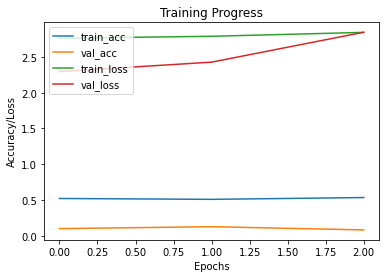

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Training Progress")
    plt.ylabel("Accuracy/Loss")
    plt.xlabel("Epochs")
    plt.legend(["train_acc", "val_acc", "train_loss", "val_loss"], loc="upper left")
    plt.show()


plot_hist(history)

# **CUT MIX**

In [ ]:
import os
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import time
from tqdm import tqdm
dir='/content/drive/MyDrive/1108 HW Samples(Resized)/'
df=pd.read_csv('/content/drive/MyDrive/HW Samples (1108)/Label.csv')[[ 'FileName', 'Extraversion', 'Conscientiousness','Emotional Stability ', 'Agreeableness ', 'Open to Experience ']]
def code(x):
  if x in ['average','Average']:
    return 1
  elif x in [' High','High','Hihg','Very High','Very high','high']:
    return 2
  else:
    return 0

for i in range(1,6):
  df.iloc[:,i]=df.iloc[:,i].apply(code)

file_paths=df['FileName'].values

_,_,files=next(os.walk(dir))
mark=[]
for i in file_paths:
  for j in files:
    if i == j[:-4]:
      mark.append(j)

file_path=np.array(mark)
y=df['Open to Experience '].values.astype(np.float32)

low, average, high = (df['Open to Experience ']==0).sum(),(df['Open to Experience ']==1).sum(),(df['Open to Experience ']==2).sum()
total = low+average+high
print('Examples:\n    Total: {}\n    low: {} ({:.2f}% of total)\n'.format(
    total, low, 100 * low / total))
print('Examples:\n    Total: {}\n    average: {} ({:.2f}% of total)\n'.format(
    total, average, 100 * average / total))
print('Examples:\n    Total: {}\n    high: {} ({:.2f}% of total)\n'.format(
    total, high, 100 * high / total))

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / low) * (total / 3.0)
weight_for_1 = (1 / average) * (total / 3.0)
weight_for_2 = (1 / high) * (total / 3.0)
class_weight = {0: weight_for_0, 1: weight_for_1, 2:weight_for_2}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 1: {:.2f}'.format(weight_for_2))

Examples:
    Total: 1108
    low: 48 (4.33% of total)

Examples:
    Total: 1108
    average: 754 (68.05% of total)

Examples:
    Total: 1108
    high: 306 (27.62% of total)

Weight for class 0: 7.69
Weight for class 1: 0.49
Weight for class 1: 1.21


In [ ]:
IMG_SIZE=CROP_TO = 299
RESIZE_TO = 400
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 32

In [ ]:
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


@tf.function
def get_box(lambda_value):
    cut_rat = tf.math.sqrt(1.0 - lambda_value)

    cut_w = IMG_SIZE * cut_rat  # rw
    cut_w = tf.cast(cut_w, tf.int32)

    cut_h = IMG_SIZE * cut_rat  # rh
    cut_h = tf.cast(cut_h, tf.int32)

    cut_x = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # rx
    cut_y = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # ry

    boundaryx1 = tf.clip_by_value(cut_x[0] - cut_w // 2, 0, IMG_SIZE)
    boundaryy1 = tf.clip_by_value(cut_y[0] - cut_h // 2, 0, IMG_SIZE)
    bbx2 = tf.clip_by_value(cut_x[0] + cut_w // 2, 0, IMG_SIZE)
    bby2 = tf.clip_by_value(cut_y[0] + cut_h // 2, 0, IMG_SIZE)

    target_h = bby2 - boundaryy1
    if target_h == 0:
        target_h += 1

    target_w = bbx2 - boundaryx1
    if target_w == 0:
        target_w += 1

    return boundaryx1, boundaryy1, target_h, target_w


@tf.function
def cutmix(train_ds_one, train_ds_two):
    (image1, label1), (image2, label2) = train_ds_one, train_ds_two

    alpha = [0.25]
    beta = [0.25]

    # Get a sample from the Beta distribution
    lambda_value = sample_beta_distribution(1, alpha, beta)

    # Define Lambda
    lambda_value = lambda_value[0][0]

    # Get the bounding box offsets, heights and widths
    boundaryx1, boundaryy1, target_h, target_w = get_box(lambda_value)

    # Get a patch from the second image (`image2`)
    crop2 = tf.image.crop_to_bounding_box(
        image2, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image2` patch (`crop2`) with the same offset
    image2 = tf.image.pad_to_bounding_box(
        crop2, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )
    # Get a patch from the first image (`image1`)
    crop1 = tf.image.crop_to_bounding_box(
        image1, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image1` patch (`crop1`) with the same offset
    img1 = tf.image.pad_to_bounding_box(
        crop1, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )

    # Modify the first image by subtracting the patch from `image1`
    # (before applying the `image2` patch)
    image1 = image1 - img1
    # Add the modified `image1` and `image2`  together to get the CutMix image
    image = image1 + image2

    # Adjust Lambda in accordance to the pixel ration
    lambda_value = 1 - (target_w * target_h) / (IMG_SIZE * IMG_SIZE)
    lambda_value = tf.cast(lambda_value, tf.float32)

    # Combine the labels of both images
    label = lambda_value * label1 + (1 - lambda_value) * label2
    return image, label

In [ ]:
@tf.function
def read_image(image_file,label):
  img=tf.io.read_file(dir+image_file)
  img=tf.image.decode_image(img,channels=3, expand_animations = False,dtype=tf.float32)
  img = tf.image.random_flip_left_right(img)
  img = tf.image.resize(img, (RESIZE_TO, RESIZE_TO))
  img = tf.image.random_crop(img, (CROP_TO, CROP_TO, 3))
  #img = (img / 127.5)-1
  return img,label


@tf.function
def preprocess_test(image_file, label):
  img=tf.io.read_file(dir+image_file)
  img=tf.image.decode_image(img,channels=3, expand_animations = False,dtype=tf.float32)
  img = tf.image.resize(img, (CROP_TO, CROP_TO))
  #img = (img / 127.5)-1
  return (img, label)

In [ ]:
train_size = int(0.9 * 1108)

ds_train=tf.data.Dataset.from_tensor_slices((file_path,y))
ds_train=ds_train
train_dataset = ds_train.take(train_size)
val_dataset = ds_train.skip(train_size)

train_ds_one=(
    train_dataset
    .shuffle(100)
    .map(read_image, num_parallel_calls=AUTO))

train_ds_two=(
    train_dataset
    .shuffle(100)
    .map(read_image, num_parallel_calls=AUTO))

train_ds_simple=(
    train_dataset
    .map(read_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO))

train_ds=tf.data.Dataset.zip((train_ds_one, train_ds_two))

test_ds=(
    val_dataset
    .map(preprocess_test, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO))

In [ ]:
# Create the new dataset using our `cutmix` utility
train_ds_cmu = (
    train_ds.shuffle(100)
    .map(cutmix, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

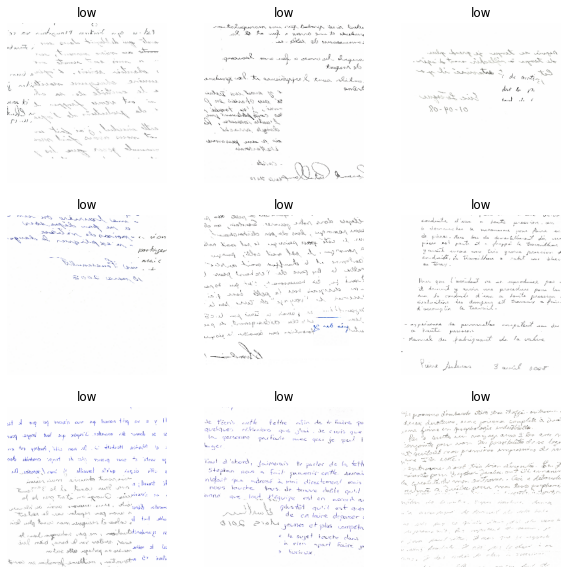

In [ ]:
class_names=['low','average','high']
image_batch, label_batch = next(iter(train_ds_cmu))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(class_names[np.argmax(label_batch[i])])
    plt.imshow(image_batch[i])
    plt.axis("off")

In [ ]:
def resnet_layer(
    inputs,
    num_filters=16,
    kernel_size=3,
    strides=1,
    activation="relu",
    batch_normalization=True,
    conv_first=True,
):
    conv = keras.layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        strides=strides,
        padding="same",
        kernel_initializer="he_normal",
        kernel_regularizer=keras.regularizers.l2(1e-4),
    )
    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = keras.layers.BatchNormalization()(x)
        if activation is not None:
            x = keras.layers.Activation(activation)(x)
    else:
        if batch_normalization:
            x = keras.layers.BatchNormalization()(x)
        if activation is not None:
            x = keras.layers.Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v20(input_shape, depth, num_classes=3):
    if (depth - 2) % 6 != 0:
        raise ValueError("depth should be 6n+2 (eg 20, 32, 44 in [a])")
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = keras.layers.Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x, num_filters=num_filters, strides=strides)
            y = resnet_layer(inputs=y, num_filters=num_filters, activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(
                    inputs=x,
                    num_filters=num_filters,
                    kernel_size=1,
                    strides=strides,
                    activation=None,
                    batch_normalization=False,
                )
            x = keras.layers.add([x, y])
            x = keras.layers.Activation("relu")(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = keras.layers.AveragePooling2D(pool_size=8)(x)
    y = keras.layers.Flatten()(x)
    outputs = keras.layers.Dense(
        num_classes, activation="softmax", kernel_initializer="he_normal"
    )(y)

    # Instantiate model.
    model = keras.models.Model(inputs=inputs, outputs=outputs)
    return model


def training_model():
    return resnet_v20((299, 299, 3), 20)


initial_model = training_model()
initial_model.save_weights("initial_weights.h5")

In [ ]:
learning_rate = 0.003 * BATCH_SIZE / 64
SCHEDULE_BOUNDARIES = [
    200,
    300,
    400,
]
# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=SCHEDULE_BOUNDARIES,
    values=[
        learning_rate,
        learning_rate * 0.1,
        learning_rate * 0.01,
        learning_rate * 0.001,
    ],
)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)
loss_fn = keras.losses.SparseCategoricalCrossentropy()


In [ ]:
model = training_model()
model.load_weights("initial_weights.h5")

model.compile(loss=loss_fn, optimizer=optimizer, metrics=["accuracy"])
model.fit(train_ds_cmu, validation_data=test_ds, epochs=15)

test_loss, test_accuracy = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_accuracy * 100))

Epoch 1/15
32/32 [==============================] - 541s 13s/step - loss: 6.1028 - accuracy: 0.3521 - val_loss: 3.9812 - val_accuracy: 0.8649
Epoch 2/15
32/32 [==============================] - 493s 13s/step - loss: 1.2957 - accuracy: 0.3972 - val_loss: 0.7666 - val_accuracy: 0.8649
Epoch 3/15
32/32 [==============================] - 491s 13s/step - loss: 0.7816 - accuracy: 0.4483 - val_loss: 0.6607 - val_accuracy: 0.8649
Epoch 4/15
32/32 [==============================] - 511s 13s/step - loss: 0.7646 - accuracy: 0.4524 - val_loss: 0.6679 - val_accuracy: 0.8649
Epoch 5/15
32/32 [==============================] - 503s 13s/step - loss: 0.7165 - accuracy: 0.4463 - val_loss: 0.6920 - val_accuracy: 0.8649
Epoch 6/15
32/32 [==============================] - 503s 13s/step - loss: 0.7227 - accuracy: 0.4493 - val_loss: 0.6939 - val_accuracy: 0.8649
Epoch 7/15
32/32 [==============================] - 501s 13s/step - loss: 0.7361 - accuracy: 0.4423 - val_loss: 0.7531 - val_accuracy: 0.8649
Epoch 

In [ ]:
model = training_model()
model.load_weights("initial_weights.h5")
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(train_ds_simple, validation_data=test_ds, epochs=15)

test_loss, test_accuracy = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_accuracy * 100))

# **SMOTE**

In [ ]:
import os
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import time
from tqdm import tqdm
dir='/content/drive/MyDrive/1108 HW Samples(Resized)/'
df=pd.read_csv('/content/drive/MyDrive/HW Samples (1108)/Label.csv')[[ 'FileName', 'Extraversion', 'Conscientiousness','Emotional Stability ', 'Agreeableness ', 'Open to Experience ']]
def code(x):
  if x in ['average','Average']:
    return 1
  elif x in [' High','High','Hihg','Very High','Very high','high']:
    return 2
  else:
    return 0

for i in range(1,6):
  df.iloc[:,i]=df.iloc[:,i].apply(code)

file_paths=df['FileName'].values

_,_,files=next(os.walk(dir))
mark=[]
for i in file_paths:
  for j in files:
    if i == j[:-4]:
      mark.append(j)

file_path=np.array(mark)
y=df['Extraversion'].values.astype(np.float32)

low, average, high = (df['Open to Experience ']==0).sum(),(df['Open to Experience ']==1).sum(),(df['Open to Experience ']==2).sum()
total = low+average+high
print('Examples:\n    Total: {}\n    low: {} ({:.2f}% of total)\n'.format(
    total, low, 100 * low / total))
print('Examples:\n    Total: {}\n    average: {} ({:.2f}% of total)\n'.format(
    total, average, 100 * average / total))
print('Examples:\n    Total: {}\n    high: {} ({:.2f}% of total)\n'.format(
    total, high, 100 * high / total))

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / low) * (total / 3.0)
weight_for_1 = (1 / average) * (total / 3.0)
weight_for_2 = (1 / high) * (total / 3.0)
class_weight = {0: weight_for_0, 1: weight_for_1, 2:weight_for_2}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 1: {:.2f}'.format(weight_for_2))

Examples:
    Total: 1108
    low: 48 (4.33% of total)

Examples:
    Total: 1108
    average: 754 (68.05% of total)

Examples:
    Total: 1108
    high: 306 (27.62% of total)

Weight for class 0: 7.69
Weight for class 1: 0.49
Weight for class 1: 1.21


In [ ]:
from imblearn.over_sampling import SMOTE
invert_paths={}
for i in range(1108):
  invert_paths[file_path[i]]=i

invert_paths1=dict((value,key ) for (key, value) in invert_paths.items())

smt = SMOTE()
Xs_train, ys_train = smt.fit_resample(np.array(list(invert_paths.values())).reshape(-1,1), y.reshape(-1,1))
Xs_train=Xs_train.flatten()
ys_train=ys_train.flatten()
x=np.array([invert_paths1[i] for i in Xs_train])

In [ ]:
IMG_SIZE=CROP_TO = 299
RESIZE_TO = 5000
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 32

In [ ]:
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


@tf.function
def get_box(lambda_value):
    cut_rat = tf.math.sqrt(1.0 - lambda_value)

    cut_w = IMG_SIZE * cut_rat  # rw
    cut_w = tf.cast(cut_w, tf.int32)

    cut_h = IMG_SIZE * cut_rat  # rh
    cut_h = tf.cast(cut_h, tf.int32)

    cut_x = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # rx
    cut_y = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # ry

    boundaryx1 = tf.clip_by_value(cut_x[0] - cut_w // 2, 0, IMG_SIZE)
    boundaryy1 = tf.clip_by_value(cut_y[0] - cut_h // 2, 0, IMG_SIZE)
    bbx2 = tf.clip_by_value(cut_x[0] + cut_w // 2, 0, IMG_SIZE)
    bby2 = tf.clip_by_value(cut_y[0] + cut_h // 2, 0, IMG_SIZE)

    target_h = bby2 - boundaryy1
    if target_h == 0:
        target_h += 1

    target_w = bbx2 - boundaryx1
    if target_w == 0:
        target_w += 1

    return boundaryx1, boundaryy1, target_h, target_w


@tf.function
def cutmix(train_ds_one, train_ds_two):
    (image1, label1), (image2, label2) = train_ds_one, train_ds_two

    alpha = [0.25]
    beta = [0.25]

    # Get a sample from the Beta distribution
    lambda_value = sample_beta_distribution(1, alpha, beta)

    # Define Lambda
    lambda_value = lambda_value[0][0]

    # Get the bounding box offsets, heights and widths
    boundaryx1, boundaryy1, target_h, target_w = get_box(lambda_value)

    # Get a patch from the second image (`image2`)
    crop2 = tf.image.crop_to_bounding_box(
        image2, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image2` patch (`crop2`) with the same offset
    image2 = tf.image.pad_to_bounding_box(
        crop2, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )
    # Get a patch from the first image (`image1`)
    crop1 = tf.image.crop_to_bounding_box(
        image1, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image1` patch (`crop1`) with the same offset
    img1 = tf.image.pad_to_bounding_box(
        crop1, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )

    # Modify the first image by subtracting the patch from `image1`
    # (before applying the `image2` patch)
    image1 = image1 - img1
    # Add the modified `image1` and `image2`  together to get the CutMix image
    image = image1 + image2

    # Adjust Lambda in accordance to the pixel ration
    lambda_value = 1 - (target_w * target_h) / (IMG_SIZE * IMG_SIZE)
    lambda_value = tf.cast(lambda_value, tf.float32)

    # Combine the labels of both images
    label = lambda_value * label1 + (1 - lambda_value) * label2
    return image, label

In [ ]:
@tf.function
def read_image(image_file,label):
  img=tf.io.read_file(dir+image_file)
  img=tf.image.decode_image(img,channels=3, expand_animations = False,dtype=tf.float32)
  img = tf.image.random_flip_left_right(img)
  img = tf.image.resize(img, (RESIZE_TO, RESIZE_TO))
  img = tf.image.random_crop(img, (CROP_TO, CROP_TO, 3))
  #img = (img / 127.5)-1
  return img,label


@tf.function
def preprocess_test(image_file, label):
  img=tf.io.read_file(dir+image_file)
  img=tf.image.decode_image(img,channels=3, expand_animations = False,dtype=tf.float32)
  img = tf.image.resize(img, (CROP_TO, CROP_TO))
  #img = (img / 127.5)-1
  return (img, label)

In [ ]:
train_size = int(0.9 * 1108)

ds_train=tf.data.Dataset.from_tensor_slices((x,ys_train))
ds_train=ds_train
train_dataset = ds_train.take(train_size)
val_dataset = ds_train.skip(train_size)

train_ds_one=(
    train_dataset
    .shuffle(100)
    .map(read_image, num_parallel_calls=AUTO))

train_ds_two=(
    train_dataset
    .shuffle(100)
    .map(read_image, num_parallel_calls=AUTO))

train_ds_simple=(
    train_dataset
    .map(read_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO))

train_ds=tf.data.Dataset.zip((train_ds_one, train_ds_two))

test_ds=(
    val_dataset
    .map(preprocess_test, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO))

In [ ]:
# Create the new dataset using our `cutmix` utility
train_ds_cmu = (
    train_ds.shuffle(100)
    .map(cutmix, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

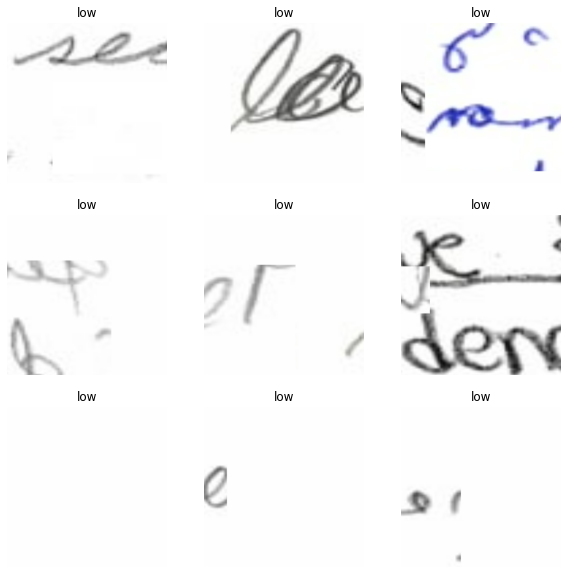

In [ ]:
class_names=['low','average','high']
image_batch, label_batch = next(iter(train_ds_cmu))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(class_names[np.argmax(label_batch[i])])
    plt.imshow(image_batch[i])
    plt.axis("off")

In [ ]:
def resnet_layer(
    inputs,
    num_filters=16,
    kernel_size=3,
    strides=1,
    activation="relu",
    batch_normalization=True,
    conv_first=True,
):
    conv = keras.layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        strides=strides,
        padding="same",
        kernel_initializer="he_normal",
        kernel_regularizer=keras.regularizers.l2(1e-4),
    )
    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = keras.layers.BatchNormalization()(x)
        if activation is not None:
            x = keras.layers.Activation(activation)(x)
    else:
        if batch_normalization:
            x = keras.layers.BatchNormalization()(x)
        if activation is not None:
            x = keras.layers.Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v20(input_shape, depth, num_classes=3):
    if (depth - 2) % 6 != 0:
        raise ValueError("depth should be 6n+2 (eg 20, 32, 44 in [a])")
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = keras.layers.Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x, num_filters=num_filters, strides=strides)
            y = resnet_layer(inputs=y, num_filters=num_filters, activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(
                    inputs=x,
                    num_filters=num_filters,
                    kernel_size=1,
                    strides=strides,
                    activation=None,
                    batch_normalization=False,
                )
            x = keras.layers.add([x, y])
            x = keras.layers.Activation("relu")(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = keras.layers.AveragePooling2D(pool_size=8)(x)
    y = keras.layers.Flatten()(x)
    outputs = keras.layers.Dense(
        num_classes, activation="softmax", kernel_initializer="he_normal"
    )(y)

    # Instantiate model.
    model = keras.models.Model(inputs=inputs, outputs=outputs)
    return model


def training_model():
    return resnet_v20((299, 299, 3), 20)


initial_model = training_model()
initial_model.save_weights("initial_weights.h5")

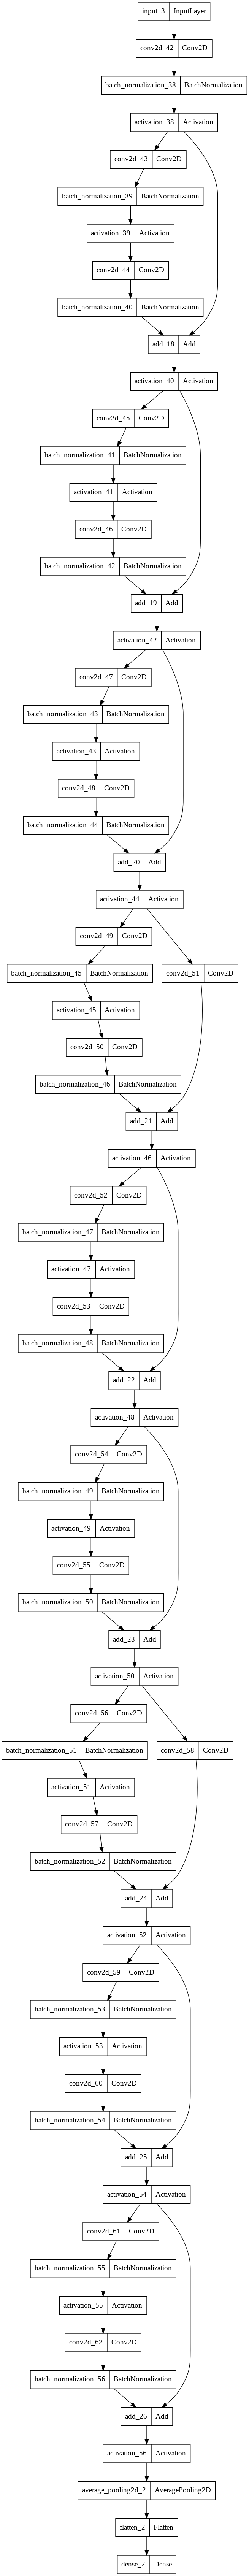

In [ ]:
tf.keras.utils.plot_model(initial_model)

In [ ]:
learning_rate = 0.003 * BATCH_SIZE / 64
SCHEDULE_BOUNDARIES = [
    200,
    300,
    400,
]
# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=SCHEDULE_BOUNDARIES,
    values=[
        learning_rate,
        learning_rate * 0.1,
        learning_rate * 0.01,
        learning_rate * 0.001,
    ],
)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)
loss_fn = keras.losses.SparseCategoricalCrossentropy()


In [ ]:
model = training_model()
model.load_weights("initial_weights.h5")

model.compile(loss=loss_fn, optimizer=optimizer, metrics=["accuracy"])
model.fit(train_ds_cmu, validation_data=test_ds, epochs=15)

Epoch 1/15
32/32 [==============================] - 237s 7s/step - loss: 1.4298 - accuracy: 0.3972 - val_loss: 8.6426 - val_accuracy: 0.0759
Epoch 2/15
32/32 [==============================] - 243s 7s/step - loss: 0.8182 - accuracy: 0.4283 - val_loss: 2.6410 - val_accuracy: 0.0759
Epoch 3/15
32/32 [==============================] - 236s 7s/step - loss: 0.7602 - accuracy: 0.4443 - val_loss: 3.6393 - val_accuracy: 0.0759
Epoch 4/15
32/32 [==============================] - 234s 7s/step - loss: 0.7592 - accuracy: 0.4453 - val_loss: 2.7942 - val_accuracy: 0.0759
Epoch 5/15
32/32 [==============================] - 234s 7s/step - loss: 0.7873 - accuracy: 0.4564 - val_loss: 3.3837 - val_accuracy: 0.0759
Epoch 6/15
32/32 [==============================] - 235s 7s/step - loss: 0.7546 - accuracy: 0.4463 - val_loss: 2.9583 - val_accuracy: 0.0759
Epoch 7/15
32/32 [==============================] - 234s 7s/step - loss: 0.8127 - accuracy: 0.4353 - val_loss: 2.4390 - val_accuracy: 0.0893
Epoch 8/15
32

In [ ]:
import tensorflow as tf
from tensorflow import keras


class ClassificationModel(tf.keras.Model):
    def __init__(self):
        super(ClassificationModel, self).__init__()
        self.pretrain_model = keras.applications.MobileNet(include_top=False)
        self.input_ = self.pretrain_model.layers[0].input
        self.pretrain_output = self.pretrain_model.layers[-1].output
        self.pretrain_layers = self._layer_name

    @property
    def _layer_name(self):

        model_layer = {}
        for idx, layer in enumerate(self.pretrain_model.layers):
            model_layer[layer.name] = idx
        return model_layer

    def get_output_layer(self, layer):
        if isinstance(layer, int):
            self.pretrain_output = self.pretrain_model.layers[layer].output
        if isinstance(layer, str):
            self.pretrain_output = self.pretrain_model.layers[self.pretrain_layers[layer]].output

    def trainable_layers(self, layer):
        if isinstance(layer, int):
            for layer_ in self.pretrain_model.layers[layer:]:
                layer_.trainable = False
        if isinstance(layer, str):
            for layer_ in self.pretrain_model.layer[self._layer_name[layer]]:
                layer_.trainable = False

    @staticmethod
    def plot_model(model, name='model.png'):
        tf.keras.utils.plot_model(model, to_file=name, show_shapes=True)

    @staticmethod
    def summary_model(model):
        print(model.summary())

    def composed_model(self, branches):
        outputs = {}
        for key, value in branches.items():

            outputs[key] = keras.layers.Dense(value[0])(self.pretrain_output)

            for layer in value[1:]:
                outputs[key] = keras.layers.Dense(layer)(outputs[key])

        pretrain_model =  keras.Model(inputs=self.input_, outputs=[value for key, value in outputs.items()])

In [ ]:
base_model = ClassificationModel()
base_model.plot_model(base_model.pretrain_model)

In [ ]:
new_model = base_model.composed_model(branches={'out1':[100, 10], 'out2':[200, 100, 9]})

In [ ]:
base_model.plot_model(new_model)